# 使用 Huggingface Trainer API 微调 BERT 模型

Huggingface 提供了一个可以直接使用的 Trainer API，使用这个 API 训练模型与直接使用 PyTorch 训练模型有以下区别：
- 不需要手动创建 DataLoader
- 不需要手动编写训练循环和验证循环

下面使用 Huggingface Trainer API 在 BERT 上微调一个 GLUE 任务，细节如下：
- pretrained model: `bert-base-uncased`
- dataset: `glue/sst2`

In [1]:
from datasets import load_dataset, load_metric
from transformers import (
    AutoConfig, 
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    EvalPrediction,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
import torch
import seaborn as sns

## 加载数据集

通过 `datasets.load_dataset` 从 Hub 中加载 glue/sst2 数据集，其中包括：
- 训练集：train
- 验证集：validation
- 测试集：test

### 加载原始数据集

该数据集包含train、validation、test三个子集，每个样本都由sentence、label、idx三个字段组成，其中sentence是原始语句，所以训练模型前需要先对其进行分词。

In [2]:
raw_datasets = load_dataset("glue", "sst2")
raw_datasets

Reusing dataset glue (/home/wh/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

### 加载分词器并对原始数据集分词

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

In [4]:
input_ids = tokenizer.encode("Roma is not built in a day.", add_special_tokens=False)
tokens = [tokenizer.decode(i) for i in input_ids]
print(input_ids)
print(tokens)

[12836, 2003, 2025, 2328, 1999, 1037, 2154, 1012]
['roma', 'is', 'not', 'built', 'in', 'a', 'day', '.']


统计训练集中每个样本分词后的 token 个数，为后面设置截断的`max_length`提供参考

In [5]:
token_counts = []
for example in raw_datasets["train"]:
    token_counts.append(len(tokenizer.encode(example["sentence"], add_special_tokens=False)))

len(token_counts)

67349

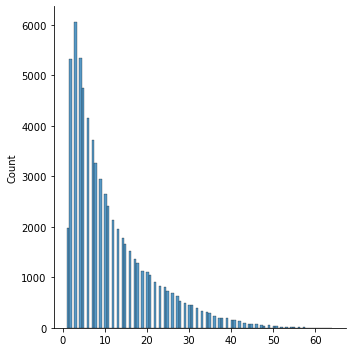

In [6]:
sns.displot(token_counts, kind="hist")

从上图可以看到 glue/sst2 中训练样本的句子长度大都在 60 以下，所以在分词时我们指定 `max_length=60` 是一个合理选择

In [7]:
def preprocessing(examples):
    """用于分词的预处理程序"""
    return tokenizer(examples["sentence"], padding="max_length", max_length=60, truncation=True)

In [8]:
tokenized_datasets = raw_datasets.map(preprocessing, batched=True)

  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

可以看到分词后数据集中增加了input_ids、token_type_ids、attention_mask三个字段

In [9]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [10]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

In [11]:
train_dataset

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 67349
})

模型不需要使用 `sentence` 和 `idx`，将其移除

In [12]:
train_dataset = train_dataset.remove_columns(["sentence", "idx"])
eval_dataset = eval_dataset.remove_columns(["sentence", "idx"])

In [13]:
train_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 67349
})

In [14]:
labels = train_dataset.features["label"].names
labels

['negative', 'positive']

## 加载预训练的BERT模型配置和分词器

In [15]:
config = AutoConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2,           # SST-2是一个二分类任务
    finetuning_task="SST-2"
)

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    config=config
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
model.config.label2id = {"negative": 0, "positive": 1}
model.config.id2label = {0: "negative", 1: "positive"}

## 训练模型

### 计算模型评估指标

通过 `datasets.load_metric` 从 Hub 中加载 glue/sst2 的评估指标，改评估指标计算预测的准确率 accuracy。

In [18]:
metric = load_metric("glue", "sst2")

In [19]:
metric.compute(predictions=[1, 1, 0], references=[1, 0, 0])

{'accuracy': 0.6666666666666666}

定义 `compute_metrics` 计算模型评估指标，参数 EvalPrediction 为 Trainer 调用该函数时传入的参数，其包含如下属性：
- `predictions` (np.ndarray) — 模型的预测
- `label_ids` (np.ndarray) — 真实标签

详见[文档](https://huggingface.co/docs/transformers/v4.17.0/en/internal/trainer_utils#transformers.EvalPrediction)

In [20]:
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

### 初始化 Trainer

In [21]:
# 设置训练参数
batch_size = 64
seed = 2022
epochs = 1

training_args = TrainingArguments(
    output_dir="./result/bert-base-uncased-sst2",
    overwrite_output_dir=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy="no",
    seed=seed,
    num_train_epochs=epochs,
    optim="adamw_torch", # 默认使用adamw_hf，会收到deprecated warning
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

### 微调模型

In [24]:
train_result = trainer.train()
train_result.metrics

***** Running training *****
  Num examples = 67349
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1053


Step,Training Loss
500,0.125100
1000,0.117500




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 295.2504,
 'train_samples_per_second': 228.108,
 'train_steps_per_second': 3.566,
 'total_flos': 2167367040752400.0,
 'train_loss': 0.12180435691463981,
 'epoch': 1.0}

In [25]:
trainer.save_model()

Saving model checkpoint to ./result/bert-base-uncased-sst2
Configuration saved in ./result/bert-base-uncased-sst2/config.json
Model weights saved in ./result/bert-base-uncased-sst2/pytorch_model.bin
tokenizer config file saved in ./result/bert-base-uncased-sst2/tokenizer_config.json
Special tokens file saved in ./result/bert-base-uncased-sst2/special_tokens_map.json


### 模型评估

使用 trainer 进行评估

In [26]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 872
  Batch size = 64


{'eval_loss': 0.22813807427883148,
 'eval_accuracy': 0.9185779816513762,
 'eval_runtime': 1.1923,
 'eval_samples_per_second': 731.345,
 'eval_steps_per_second': 11.742,
 'epoch': 1.0}

使用 scikit-learn 提供的 `confusion_matrix` 和 `classification_report` 进行评估

In [27]:
data_collator = DataCollatorWithPadding(tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, collate_fn=data_collator)

In [28]:
device = "cuda:0"

model.eval()
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in eval_dataloader:
        true_labels.extend(batch["labels"].tolist())
        batch.to(device)
        result = model(**batch)
        pred_labels.extend(result.logits.argmax(1).tolist())

In [29]:
len(true_labels), len(pred_labels)

(872, 872)

In [30]:
true_labels[:10], pred_labels[:10]

([1, 0, 1, 1, 0, 1, 0, 0, 1, 0], [1, 0, 1, 1, 0, 1, 0, 0, 1, 0])

In [31]:
# 混淆矩阵
print(confusion_matrix(true_labels, pred_labels))

[[387  41]
 [ 30 414]]


In [32]:
print(classification_report(true_labels, pred_labels, labels=[0, 1], target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.93      0.90      0.92       428
    positive       0.91      0.93      0.92       444

    accuracy                           0.92       872
   macro avg       0.92      0.92      0.92       872
weighted avg       0.92      0.92      0.92       872

